In [1]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset

%load_ext autoreload
%autoreload 3

### Re-compute bulk formula prediction

In [2]:
# Use bulk algorithm 3.0 to be consistent with GOTM test
from mlflux.datafunc import load_psd
ds_psd = load_psd('../../data/PSD/fluxes_all_cruises_compilation.nc', algo='coare3p0') # This load_psd function includes applybulk
ds_psd['tauby'] = xr.zeros_like(ds_psd['taubx']) # bulk formula doesn't predict tauy
ds_psd.to_netcdf('../../data/Processed/psd_coare3p0.nc')

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


Number of samples: 10079


/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


In [2]:
psd = xr.load_dataset('../../data/Processed/psd_coare3p0.nc')

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


### Fit residual

In [42]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff 
import torch.nn as nn

class poo(nn.Module):
    def __init__(self, n_in, n_out, hidden_channels=[24, 24], degree=None, ACTIVATION='no'):  
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out
        print('Artificial nn with zero prediction!')
    def forward(self, x):
        return torch.zeros((x.shape[0], self.n_out))

class Fluxdiff(FluxANNs):
    def __init__(self, params={}):
        super().__init__(params)
        self.mean_func = poo(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para) 

# class RealFluxDataset(Dataset):
#     def __init__(self, ds, input_keys=['U','tsea','tair','rh'], output_keys=['taucx','taucy','hsc','hlc'], 
#                  bulk_keys=['taubx','tauby','hsb','hlb'], weightfunc=sample_weights):
        
#         ###### Assemble input and output features ######
#         self.X = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))
#         self.Y = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in output_keys]).astype('float32'))
#         ###### Assemble bulk ######
#         self.Bulk = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in bulk_keys]).astype('float32'))    
#         ###### Weights according to weightfunc of choice, weight needs to match output dimension ######
#         weights = weightfunc(self.X[:,0]).reshape(-1,1)
#         weights = np.repeat(weights, len(output_keys), axis=1)
#         self.W = torch.tensor(weights.astype('float32'))
        
#     def __len__(self):
#         return self.X.shape[0]

#     def __getitem__(self, idx):
#         return self.X[idx], self.Y[idx], self.W[idx]
        
class ResidualDataset(RealFluxDataset):
    def __init__(self, ds, input_keys=['U','tsea','tair','rh'], output_keys=['taucx','taucy','hsc','hlc'], 
                 bulk_keys=['taubx','tauby','hsb','hlb']):
        super().__init__(ds=ds, input_keys=input_keys, output_keys=output_keys, bulk_keys=bulk_keys)
        self.Y = self.Y - self.Bulk

In [62]:
from adapt.instance_based import KLIEP
from mlflux.gotm import read2010

# The target distribution
path = '/home/jw8736/code-5.2.1/cases/ows_papa/'
df = read2010(path, datetimeformat='%Y-%m-%d %H:%M:%S') 
df_ = df.set_index('datetime')
ds = xr.Dataset.from_dataframe(df_)
ds = ds.sel(datetime=slice('2012-01-01','2012-12-31'))

X_target = np.hstack([np.array(((ds.ux)**2+(ds.uy)**2)**0.5).reshape(-1,1), 
               (np.array(ds.sst)-np.array(ds.t)).reshape(-1,1),
               np.array(ds.rh).reshape(-1,1),
              ])
X_sample = np.hstack([np.array(psd.U).reshape(-1,1), np.array(psd.tsea-psd.tair).reshape(-1,1), np.array(psd.rh).reshape(-1,1)])

# X_target = np.hstack([np.array(((ds.ux)**2+(ds.uy)**2)**0.5).reshape(-1,1)/10., 
#                (np.array(ds.sst)-np.array(ds.t)).reshape(-1,1)/10.,
#                np.array(ds.rh).reshape(-1,1)/100.,
#               ])
# X_sample = np.hstack([np.array(psd.U).reshape(-1,1)/10., np.array(psd.tsea-psd.tair).reshape(-1,1)/10., np.array(psd.rh).reshape(-1,1)/100.])

kliep = KLIEP(kernel="rbf", gamma=[10**(i-2) for i in range(7)], random_state=0)
kliep_weights = kliep.fit_weights(X_sample, X_target)

Cross Validation process...
Parameters {'gamma': 0.01} -- J-score = 1.372 (0.031)
Parameters {'gamma': 0.1} -- J-score = 1.919 (0.045)
Parameters {'gamma': 1} -- J-score = 1.367 (0.309)
Parameters {'gamma': 10} -- J-score = -8.612 (0.962)
Parameters {'gamma': 100} -- J-score = -32.828 (0.506)


/ext3/miniconda3/lib/python3.11/site-packages/adapt/instance_based/_kliep.py:492: UserWarning: Not enough centers, only 13 centers found. Maybe consider a different value of kernel parameter.
  warnings.warn("Not enough centers, only %i centers found. Maybe consider a different value of kernel parameter."%len(centers))
/ext3/miniconda3/lib/python3.11/site-packages/adapt/instance_based/_kliep.py:492: UserWarning: Not enough centers, only 13 centers found. Maybe consider a different value of kernel parameter.
  warnings.warn("Not enough centers, only %i centers found. Maybe consider a different value of kernel parameter."%len(centers))
/ext3/miniconda3/lib/python3.11/site-packages/adapt/instance_based/_kliep.py:492: UserWarning: Not enough centers, only 13 centers found. Maybe consider a different value of kernel parameter.
  warnings.warn("Not enough centers, only %i centers found. Maybe consider a different value of kernel parameter."%len(centers))
/ext3/miniconda3/lib/python3.11/site-

Parameters {'gamma': 1000} -- J-score = -36.025 (0.027)


/ext3/miniconda3/lib/python3.11/site-packages/adapt/instance_based/_kliep.py:492: UserWarning: Not enough centers, only 1 centers found. Maybe consider a different value of kernel parameter.
  warnings.warn("Not enough centers, only %i centers found. Maybe consider a different value of kernel parameter."%len(centers))
/ext3/miniconda3/lib/python3.11/site-packages/adapt/instance_based/_kliep.py:492: UserWarning: Not enough centers, only 1 centers found. Maybe consider a different value of kernel parameter.
  warnings.warn("Not enough centers, only %i centers found. Maybe consider a different value of kernel parameter."%len(centers))
/ext3/miniconda3/lib/python3.11/site-packages/adapt/instance_based/_kliep.py:492: UserWarning: Not enough centers, only 1 centers found. Maybe consider a different value of kernel parameter.
  warnings.warn("Not enough centers, only %i centers found. Maybe consider a different value of kernel parameter."%len(centers))
/ext3/miniconda3/lib/python3.11/site-pac

Parameters {'gamma': 10000} -- J-score = -inf (nan)


2.1217013304003408e-19 108.77156710618168


/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

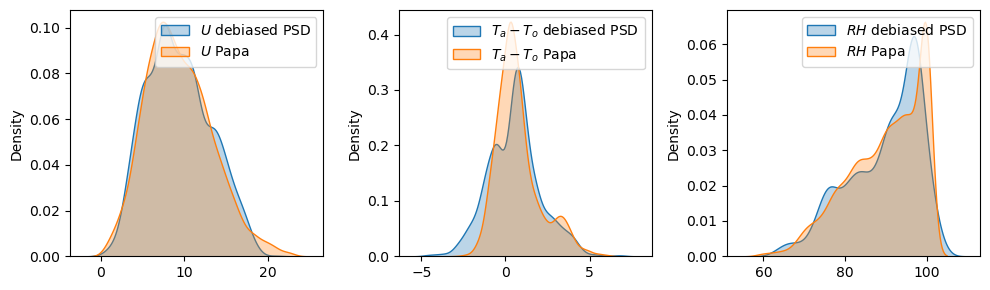

In [11]:
print(kliep_weights.min(), kliep_weights.max())

import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=[10,3])

debiasing_index = np.random.choice(len(X_sample), 2000, p=kliep_weights/kliep_weights.sum())

labels = ['$U$', '$T_a-T_o$', '$RH$']
for i, ax in enumerate(axes):
    sns.kdeplot(X_sample[debiasing_index,i], fill=True, alpha=0.3, label=labels[i]+' debiased PSD', ax=ax)
    sns.kdeplot(X_target[:,i], fill=True, alpha=0.3, label=labels[i]+' Papa', ax=ax)
    ax.legend()

plt.tight_layout()

(0.01, 10)

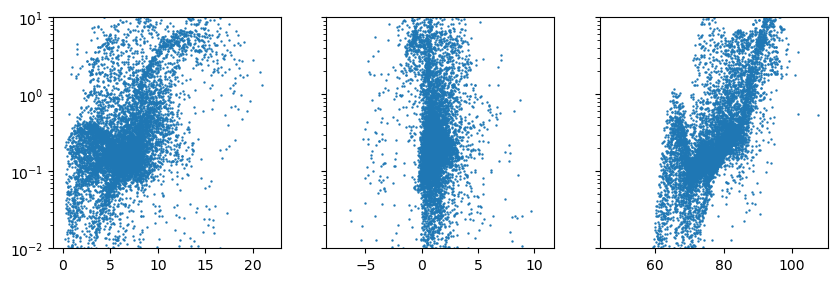

In [29]:
fig, axes = plt.subplots(1, 3, figsize=[10,3],sharey=True)
axes[0].scatter(X_sample[:,0], kliep_weights, marker='o', s=0.5)
axes[1].scatter(X_sample[:,1], kliep_weights, marker='o', s=0.5)
axes[2].scatter(X_sample[:,2], kliep_weights, marker='o', s=0.5)
axes[0].set_yscale('log'); axes[0].set_ylim([0.01,10])

In [66]:
##### Check that it's working #####
# psd['weight'] = (['time'], np.ones(psd.U.values.shape))  # uniform weights
##### With weights #####
psd['weight'] = (['time'], kliep_weights)
psd

<xarray.Dataset>
Dimensions:  (time: 10079)
Coordinates:
  * time     (time) datetime64[ns] 1996-12-22T19:00:00.288000 ... 2016-04-13T...
Data variables: (12/21)
    taucx    (time) float64 0.1895 0.6395 0.3934 ... 0.07723 0.07373 0.08168
    taucy    (time) float64 0.0333 0.1182 -0.023 ... -0.06492 -0.02255 -0.0589
    hsc      (time) float64 -29.54 -100.4 -60.81 -142.7 ... -5.808 1.075 -13.14
    hlc      (time) float64 -99.11 -180.2 -153.9 -218.3 ... -39.32 -43.95 -109.2
    U        (time) float64 12.14 16.7 16.75 17.0 ... 9.779 8.903 8.239 8.543
    tsea     (time) float64 7.569 11.82 11.86 11.91 ... 11.43 10.9 11.38 12.66
    ...       ...
    wdir     (time) float64 75.04 68.66 65.81 66.5 ... 284.7 282.9 270.4 283.4
    hlb      (time) float64 -129.8 -175.0 -181.8 -194.0 ... -17.21 -34.88 -27.76
    hsb      (time) float64 -42.07 -81.74 -73.27 -87.61 ... -2.911 3.171 -10.27
    taubx    (time) float64 0.2515 0.5628 0.5641 ... 0.1085 0.08727 0.1017
    tauby    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    weight   (time) float64 0.006158 4.959 13.3 10.83 ... 10.03 0.4509 10.11

In [69]:
''' Momentum flux models, now with weights  '''
momentum_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,32,16],'ACTIVATION':'exponential'}
# para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
# def sample_weights(x):
#     return np.where(x > 10, 1.0, 1.0)
###### Now with weights according to domain adapt algorithm #####

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    # ikeys = ['U','tsea','tair','rh','qair']
    okeys = ['taucx']
    bkeys = ['taubx']
    training_data = ResidualDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    validating_data = ResidualDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    testing_data = ResidualDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}   
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([0.]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([1.]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':500, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':False, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data, validating_data, training_paras, VERBOSE=True)
    momentum_model_ensem.append(model)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/one_output_anns/Flux41_momentum_3layers_split%g" %(i+1))
    # model.save(fname="../../saved_model/one_output_anns/Flux51_momentum_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068
Artificial nn with zero prediction!
[ 0.0018 -0.0261 -0.1628 -0.022   0.0093]
[ 0.0032 -0.0072 -0.1583 -0.0138  0.0102]
Epoch [1/500], Loss: 7.53744166
[ 0.0018 -0.0261 -0.5017 -0.031   0.0185]
[ 0.0032 -0.0072 -0.4885 -0.0195  0.0202]
Epoch [2/500], Loss: -33.18619650
[ 0.0018 -0.0261 -0.8459 -0.0441  0.0375]
[ 0.0032 -0.0072 -0.8231 -0.0277  0.0409]
Epoch [3/500], Loss: -66.77316943
[ 0.0018 -0.0261 -1.263  -0.0686  0.0907]
[ 0.0032 -0.0072 -1.2271 -0.043   0.0989]
Epoch [4/500], Loss: -103.43100247
[ 0.0018 -0.0261 -1.7045 -0.1157  0.2582]
[ 0.0032 -0.0072 -1.6482 -0.0726  0.2816]
Epoch [5/500], Loss: -148.04838320
[ 1.7980e-03 -2.6080e-02 -1.9239e+00 -1.6384e-01  5.1767e-01]
[ 0.0032 -0.0072 -1.8474 -0.1028  0.5644]
Epoch [6/500], Loss: -182.77383435
[ 1.7980e-03 -2.6080e-02 -1.9867e+00 -1.9208e-01  7.1147e-01]
[ 0.0032 -0.0072 -1.8975 -0.1206  0.7757]
Epoch [7/500], Loss: -195.09769306
[ 1.7980e-03 -2.6080e-02 -

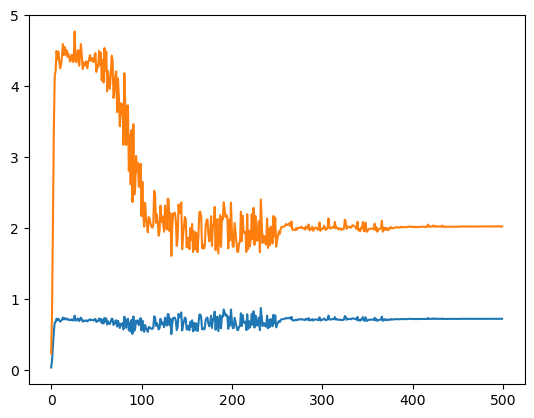

In [252]:
model = momentum_model_ensem[3]

plt.plot(np.array(model.log['training_scores'])[:,-1])
plt.plot(np.array(model.log['validating_scores'])[:,-1])

In [208]:
from scipy.stats import wasserstein_distance

def ensem_score_residual(model_ensem, keys, N=6):
    
    # Pick out the variables needed
    res_mean = []; res_var = []; di = []   
    
    for i in range(0,N):
        training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[i], PLOT=False, XVIS='samples')
        vd = RealFluxDataset(training_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])
        # vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])
        # sample from standard Gaussian for distance
        s = np.random.normal(0, 1, len(vd.X)) 

        model = model_ensem[i]
        error = vd.Y.detach().numpy() - vd.Bulk.detach().numpy()
        error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5
        # res_mean.append(np.mean(error_norm*vd.W.detach().numpy()))
        # res_var.append(np.mean(error_norm**2*vd.W.detach().numpy()))
        res_mean.append(np.mean(error_norm))
        res_var.append(np.mean(error_norm**2))
        di.append(wasserstein_distance(error_norm.squeeze(), s))
        print(np.mean(error**2),np.std(error)**2,np.mean(model.pred_var(vd.X).detach().numpy()))

    return res_mean, res_var, di

Training samples: 7005
Validating samples: 3068
Testing samples: 3068
0.0022284046 0.002189999293632519 0.0021188052
Training samples: 8463
Validating samples: 1610
Testing samples: 1610
0.0022284046 0.002189999293632519 0.002423266
Training samples: 7424
Validating samples: 2649
Testing samples: 2649
0.0022284046 0.002189999293632519 0.0024698796
Training samples: 9194
Validating samples: 879
Testing samples: 879
0.0022284046 0.002189999293632519 0.002785354
Training samples: 8826
Validating samples: 1247
Testing samples: 1247
0.0022284046 0.002189999293632519 0.0023679747
Training samples: 9453
Validating samples: 620
Testing samples: 620
0.0022284046 0.002189999293632519 0.002051699


Text(0.5, 0, 'Model number')

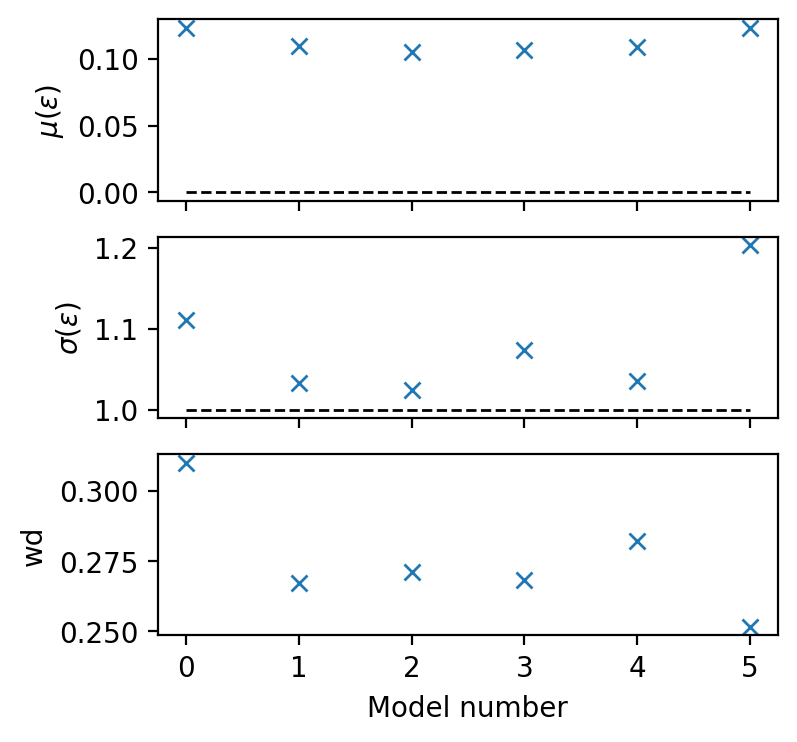

In [88]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
res_mean, res_var, di = ensem_score_residual(momentum_model_ensem, keys, N=6)

# keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
# res_mean, res_var, di = ensem_score_residual(latent_model_ensem, keys, N=6)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=[4,4], dpi=200)
axes[0].plot(res_mean, 'x')
# axes[0].set_ylim([-0.1,0.2])
axes[0].hlines(y=0., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[1].plot(res_var, 'x')
# axes[1].set_ylim([0,4])
axes[1].hlines(y=1., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[2].plot(di, 'x')
# axes[2].set_ylim([0,1.5])

axes[0].set_ylabel('$\mu(\epsilon)$')
axes[1].set_ylabel('$\sigma(\epsilon)$')
axes[2].set_ylabel('wd')
plt.xlabel('Model number')

#### Plot residuals

(-0.8, 0.8)

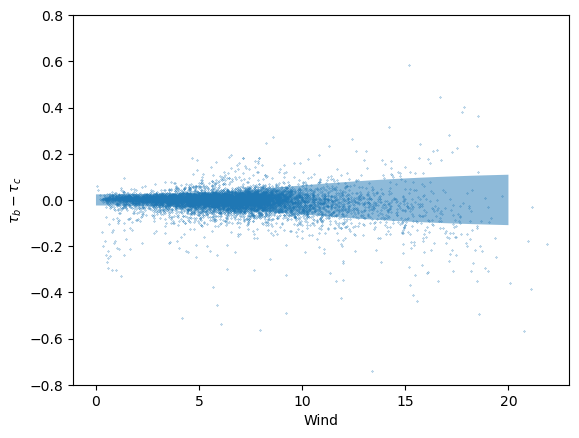

In [244]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

plt.plot(vd.X[:,0], vd.Bulk-vd.Y, '.', markersize=0.5)

U = np.linspace(0,20,101).reshape(-1,1)
Ta = np.ones([101,1]) * 20
To = np.ones([101,1]) * 20
RH = np.ones([101,1]) * 80
X = np.hstack([U,Ta,To,RH]).astype('float32')

model = momentum_model_ensem[5]
std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
plt.fill_between(x=X[:,0], y1=std_pred.flatten(), y2=-std_pred.flatten(),alpha=0.5)
# for model in momentum_model_ensem:
#     std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
#     plt.fill_between(x=X[:,0], y1=std_pred.flatten(), y2=-std_pred.flatten(),alpha=0.5)


plt.xlabel('Wind'); plt.ylabel(r'$\tau_b - \tau_c$ ')
plt.ylim([-0.8,0.8])

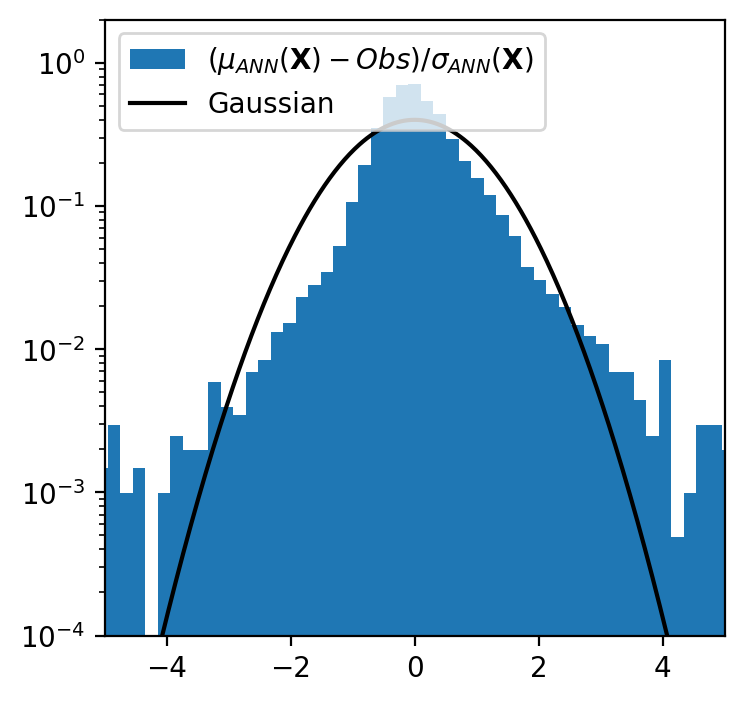

In [111]:
# debiasing_index = np.random.choice(psd.sizes['time'], 10000, p=kliep_weights/kliep_weights.sum())
# vd = ResidualDataset(psd.isel(time=debiasing_index), input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

vd = ResidualDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

i = 1
model = momentum_model_ensem[i]

mask = vd.X[:,0].numpy() < 30
error = vd.Y.detach().numpy()[mask]
error_norm = error/model.pred_var(vd.X).detach().numpy()[mask]**0.5

fig = plt.figure(figsize=(4,4),dpi=200)
plt.hist(error_norm, bins=np.linspace(-10, 10, 100), density=True, 
         label='$(\mu_{ANN}(\mathbf{X}) - Obs)/\sigma_{ANN}(\mathbf{X})$')

mu = 0      # mean
sigma = 1   # standard deviation

x = np.linspace(mu - 10*sigma, mu + 10*sigma, 1000)
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
y_ = 1/((np.pi*0.3)*(1+(x/0.3)**2))

# plt.plot(x, y_, color='r', label='Cauchy')
plt.plot(x, y, color='k', label='Gaussian')
plt.legend(loc='upper left')
plt.xlim([-5,5]) 
plt.ylim([0.0001,2])
plt.yscale('log')

### Latent heat 

In [235]:
''' Latent heat flux models '''
latent_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,32,16],'ACTIVATION':'exponential'}
# para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
# def sample_weights(x):
#     return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem[0:1]):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    # ikeys = ['U','tsea','tair','rh','qair']
    okeys = ['hlc']
    bkeys = ['hlb']
    training_data = ResidualDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    validating_data = ResidualDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    testing_data = ResidualDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}   
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([0.]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([1.]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':1000, 'num_epochs':1000, 'lr':5e-2, 'gamma':0.2,
                      'EARLYSTOPPING':False, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':100}
    log = model.fit(training_data, validating_data, training_paras, VERBOSE=False)
    latent_model_ensem.append(model)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/one_output_anns/Flux41_momentum_3layers_split%g" %(i+1))
    # model.save(fname="../../saved_model/one_output_anns/Flux51_momentum_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068
Artificial nn with zero prediction!
[ 1.2837e+03  0.0000e+00  2.8446e+01 -4.7592e-01  5.2862e+01]
[ 8.4752e+02  0.0000e+00  9.6249e+00 -2.2750e-01  1.5318e+01]
[ 1.2837e+03  0.0000e+00  9.2624e+00 -2.3686e-01  1.3094e+01]
[ 8.4752e+02  0.0000e+00  4.5465e+00 -1.1322e-01  3.7942e+00]
[ 1.2837e+03  0.0000e+00  6.4484e+00 -1.7080e-01  6.8089e+00]
[ 8.4752e+02  0.0000e+00  3.9562e+00 -8.1649e-02  1.9730e+00]
[ 1.2837e+03  0.0000e+00  5.6517e+00 -1.4462e-01  4.8816e+00]
[ 8.4752e+02  0.0000e+00  3.8400e+00 -6.9134e-02  1.4145e+00]
[ 1.2837e+03  0.0000e+00  5.3418e+00 -1.3225e-01  4.0821e+00]
[ 8.4752e+02  0.0000e+00  3.8117e+00 -6.3220e-02  1.1829e+00]
[ 1.2837e+03  0.0000e+00  5.1934e+00 -1.2560e-01  3.6816e+00]
[ 8.4752e+02  0.0000e+00  3.8043e+00 -6.0038e-02  1.0668e+00]
[ 1.2837e+03  0.0000e+00  5.1089e+00 -1.2152e-01  3.4464e+00]
[ 8.4752e+02  0.0000e+00  3.8026e+00 -5.8089e-02  9.9867e-01]
[ 1.2837e+03  0.0000e+00  

(0.0, 2.0)

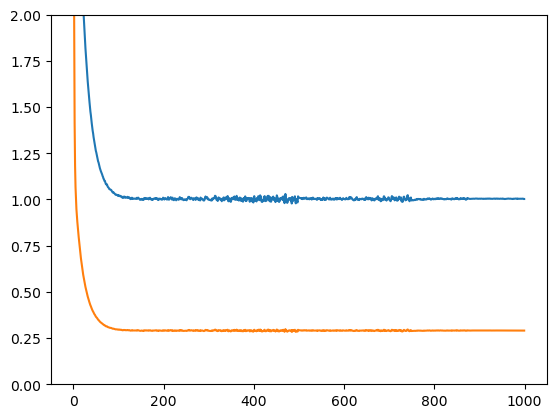

In [236]:
model = latent_model_ensem[0]

plt.plot(np.array(model.log['training_scores'])[:,-1])
plt.plot(np.array(model.log['validating_scores'])[:,-1])

# plt.plot(np.array(model.log['training_scores'])[:,1])
# plt.plot(np.array(model.log['validating_scores'])[:,1])

plt.ylim([0,2])

Text(0, 0.5, '$Q_{Lb} - Q_{Lc}$ ')

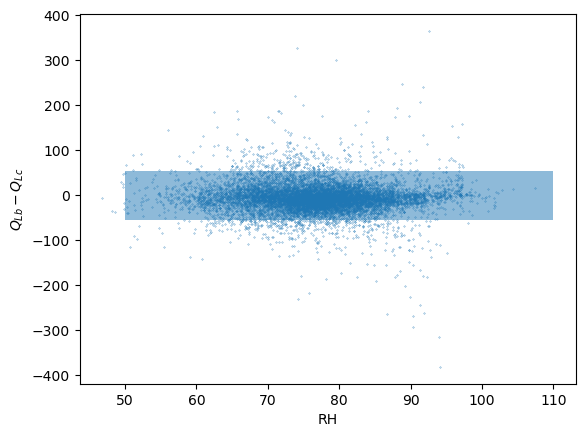

In [237]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

plt.plot(vd.X[:,-1], vd.Bulk-vd.Y, '.', markersize=0.5)


# for model in latent_model_ensem:
model = latent_model_ensem[0]
U = np.ones(101).reshape(-1,1) * 15
Ta = np.ones([101,1]) * 20
To = np.ones([101,1]) * 15
RH = np.linspace(50,110,101).reshape(-1,1)
X = np.hstack([U,Ta,To,RH]).astype('float32')

std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
plt.fill_between(x=X[:,-1], y1=std_pred.flatten(), y2=-std_pred.flatten(),alpha=0.5)


plt.xlabel('RH'); plt.ylabel(r'$Q_{Lb} - Q_{Lc}$ ')
# plt.ylim([-0.8,0.8])

Text(0, 0.5, '$Q_{Lb} - Q_{Lc}$ ')

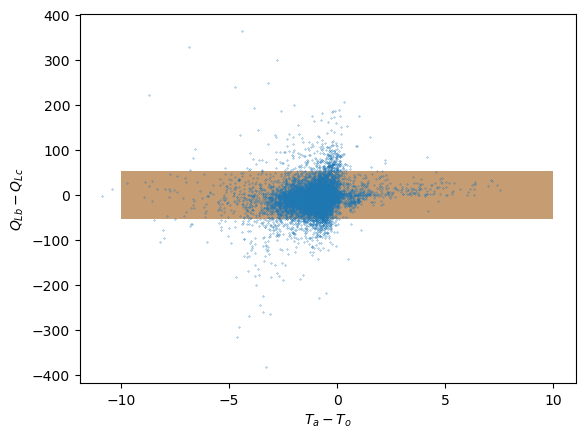

In [238]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

plt.plot(vd.X[:,2]-vd.X[:,1], vd.Bulk-vd.Y, '.', markersize=0.5)


# for model in latent_model_ensem:
model = latent_model_ensem[0]
U = np.ones([101,1]) * 20
Ta = np.linspace(0,20,101).reshape(-1,1)
To = np.ones([101,1]) * 10
RH = np.ones([101,1]) * 80
X = np.hstack([U,Ta,To,RH]).astype('float32')

std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
plt.fill_between(x=(X[:,2]-X[:,1]), y1=std_pred.flatten(), y2=-std_pred.flatten(),alpha=0.5)

model = latent_model_ensem[0]
U = np.ones([101,1]) * 4
Ta = np.linspace(5,25,101).reshape(-1,1)
To = np.ones([101,1]) * 15
RH = np.ones([101,1]) * 80
X = np.hstack([U,Ta,To,RH]).astype('float32')

std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
plt.fill_between(x=(X[:,2]-X[:,1]), y1=std_pred.flatten(), y2=-std_pred.flatten(),alpha=0.5)



plt.xlabel('$T_a-T_o$'); plt.ylabel(r'$Q_{Lb} - Q_{Lc}$ ')
# plt.ylim([-0.8,0.8])

In [213]:
from scipy.stats import wasserstein_distance

def ensem_score_residual(model_ensem, keys, N=6):
    
    # Pick out the variables needed
    res_mean = []; res_var = []; di = []   
    
    for i in range(0,N):
        training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[i], PLOT=False, XVIS='samples')
        # vd = RealFluxDataset(training_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])
        vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])
        # sample from standard Gaussian for distance
        s = np.random.normal(0, 1, len(vd.X)) 

        model = model_ensem[i]
        error = vd.Y.detach().numpy() - vd.Bulk.detach().numpy()
        error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5
        res_mean.append(np.mean(error_norm*vd.W.detach().numpy()))
        res_var.append(np.mean(error_norm**2*vd.W.detach().numpy()))
        # res_mean.append(np.mean(error_norm))
        # res_var.append(np.mean(error_norm**2))
        di.append(wasserstein_distance(error_norm.squeeze(), s))
        print(np.mean(error**2),np.std(error)**2,np.mean(model.pred_var(vd.X).detach().numpy()))

    return res_mean, res_var, di

Training samples: 7005
Validating samples: 3068
Testing samples: 3068
1150.208 1117.010254054927 2873.4314
Training samples: 8463
Validating samples: 1610
Testing samples: 1610
1150.208 1117.010254054927 2741.7703
Training samples: 7424
Validating samples: 2649
Testing samples: 2649
1150.208 1117.010254054927 2400.536
Training samples: 9194
Validating samples: 879
Testing samples: 879
1150.208 1117.010254054927 2200.8093
Training samples: 8826
Validating samples: 1247
Testing samples: 1247
1150.208 1117.010254054927 880.36145
Training samples: 9453
Validating samples: 620
Testing samples: 620
1150.208 1117.010254054927 2164.0117


Text(0.5, 0, 'Model number')

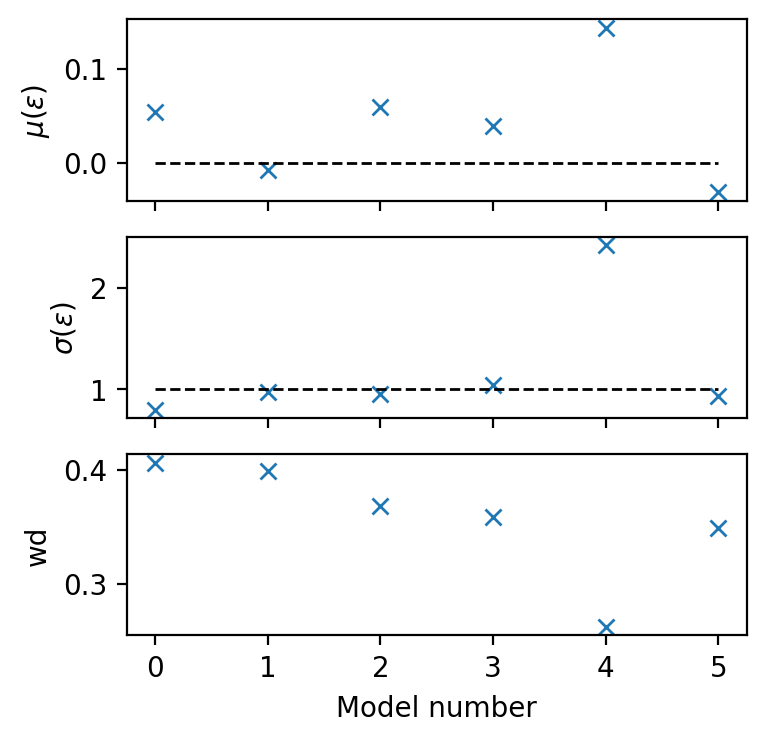

In [214]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
res_mean, res_var, di = ensem_score_residual(latent_model_ensem, keys, N=6)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=[4,4], dpi=200)
axes[0].plot(res_mean, 'x')
# axes[0].set_ylim([-0.1,0.2])
axes[0].hlines(y=0., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[1].plot(res_var, 'x')
# axes[1].set_ylim([0,4])
axes[1].hlines(y=1., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[2].plot(di, 'x')
# axes[2].set_ylim([0,1.5])

axes[0].set_ylabel('$\mu(\epsilon)$')
axes[1].set_ylabel('$\sigma(\epsilon)$')
axes[2].set_ylabel('wd')
plt.xlabel('Model number')

### Sensible heat

In [ ]:
''' Latent heat flux models '''
sensible_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,32,16],'ACTIVATION':'exponential'}
# para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
# def sample_weights(x):
#     return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem[1:2]):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    # ikeys = ['U','tsea','tair','rh','qair']
    okeys = ['hsc']
    bkeys = ['hsb']
    training_data = ResidualDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    validating_data = ResidualDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    testing_data = ResidualDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}   
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([0.]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([1.]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':1000, 'num_epochs':1000, 'lr':5e-2, 'gamma':0.2,
                      'EARLYSTOPPING':False, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':100}
    log = model.fit(training_data, validating_data, training_paras, VERBOSE=False)
    sensible_model_ensem.append(model)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/one_output_anns/Flux41_momentum_3layers_split%g" %(i+1))
    # model.save(fname="../../saved_model/one_output_anns/Flux51_momentum_3layers_split%g" %(i+1))

Training samples: 8463
Validating samples: 1610
Testing samples: 1610
Artificial nn with zero prediction!
[186.8673   0.      27.538   -0.1959  51.6601]
[ 5.5402e+02  0.0000e+00  9.2023e+00 -2.2137e-01  1.6896e+01]
[ 1.8687e+02  0.0000e+00  1.1934e+01 -1.1995e-01  1.9378e+01]
[ 5.5402e+02  0.0000e+00  4.1598e+00 -1.3558e-01  6.3376e+00]
[ 1.8687e+02  0.0000e+00  8.1208e+00 -9.0977e-02  1.1148e+01]
[ 5.5402e+02  0.0000e+00  2.9474e+00 -1.0283e-01  3.6456e+00]
[ 1.8687e+02  0.0000e+00  6.7536e+00 -7.7350e-02  8.0581e+00]
[ 5.5402e+02  0.0000e+00  2.5206e+00 -8.7431e-02  2.6352e+00]
[ 1.8687e+02  0.0000e+00  6.1407e+00 -7.0090e-02  6.6165e+00]
[ 5.5402e+02  0.0000e+00  2.3325e+00 -7.9225e-02  2.1638e+00]
[ 1.8687e+02  0.0000e+00  5.7947e+00 -6.5486e-02  5.7758e+00]
[ 5.5402e+02  0.0000e+00  2.2279e+00 -7.4021e-02  1.8888e+00]
[ 1.8687e+02  0.0000e+00  5.5861e+00 -6.2465e-02  5.2552e+00]
[ 5.5402e+02  0.0000e+00  2.1656e+00 -7.0606e-02  1.7186e+00]
[ 1.8687e+02  0.0000e+00  5.3971e+00 -5.9

In [262]:
model = sensible_model_ensem[1]

plt.plot(np.array(model.log['training_scores'])[:,-1])
plt.plot(np.array(model.log['validating_scores'])[:,-1])

# plt.plot(np.array(model.log['training_scores'])[:,1])
# plt.plot(np.array(model.log['validating_scores'])[:,1])

plt.ylim([0,2])

IndexError: list index out of range

### One net but without assumption that bulk is un-biased

In [53]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff 
import torch.nn as nn

class Fluxdiff(FluxANNs):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

In [54]:
''' Momentum flux models '''
momentum_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}
# para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    # ikeys = ['U','tsea','tair','rh','qair']
    okeys = ['taucx']
    bkeys = ['taubx']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}   
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([0.]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([0.05]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':False, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data, validating_data, training_paras, VERBOSE=False)
    momentum_model_ensem.append(model)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/one_output_anns/Flux41_momentum_3layers_split%g" %(i+1))
    # model.save(fname="../../saved_model/one_output_anns/Flux51_momentum_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 354 epochs.
training took 67.27 seconds, loss at last epoch 18.5284
Training samples: 8463
Validating samples: 1610
Testing samples: 1610


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 130 epochs.
training took 29.33 seconds, loss at last epoch 15.0894
Training samples: 7424
Validating samples: 2649
Testing samples: 2649


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 101 epochs.
training took 20.05 seconds, loss at last epoch 11.0245
Training samples: 9194
Validating samples: 879
Testing samples: 879


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 426 epochs.
training took 104.02 seconds, loss at last epoch 9.6386
Training samples: 8826
Validating samples: 1247
Testing samples: 1247


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 135 epochs.
training took 31.81 seconds, loss at last epoch 28.2969
Training samples: 9453
Validating samples: 620
Testing samples: 620


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 180 epochs.
training took 45.26 seconds, loss at last epoch 13.0900


In [57]:
def ensem_score(model_ensem, keys, N=6):
    
    # Pick out the variables needed
    vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
    res_mean = []; res_var = []; di = []   
    
    # sample from standard Gaussian for distance
    s = np.random.normal(0, 1, len(vd.X)) 

    for i in range(0,N):
        model = model_ensem[i]       
        error = model.pred_mean(vd.X).detach().numpy() - vd.Y.detach().numpy()
        error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5
        res_mean.append(error_norm.mean())
        res_var.append(error_norm.std())
        di.append(wasserstein_distance(error_norm.squeeze(), s))

    return res_mean, res_var, di

Text(0.5, 0, 'Model number')

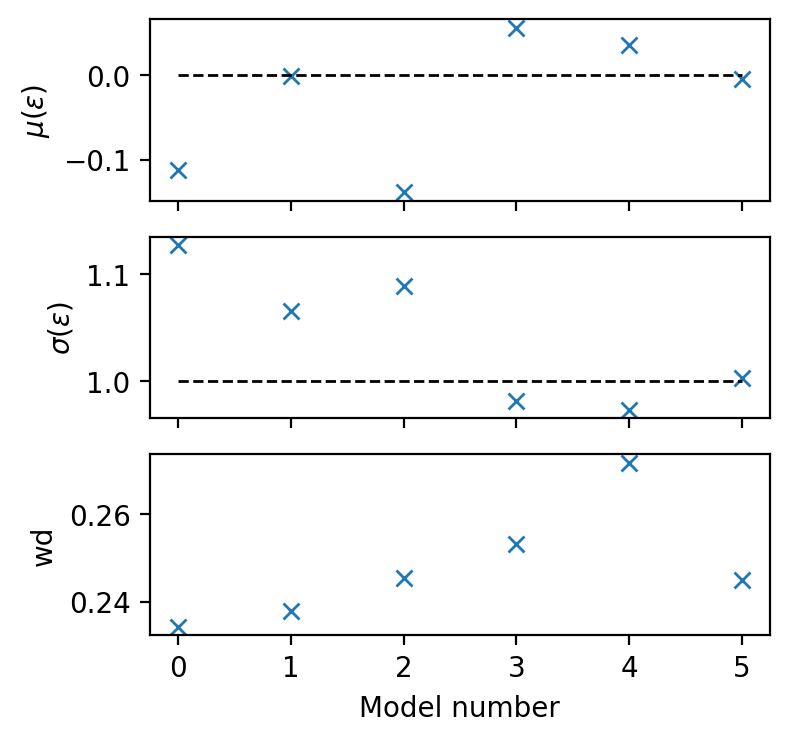

In [58]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
res_mean, res_var, di = ensem_score(momentum_model_ensem, keys, N=6)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=[4,4], dpi=200)
axes[0].plot(res_mean, 'x')
# axes[0].set_ylim([-0.1,0.2])
axes[0].hlines(y=0., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[1].plot(res_var, 'x')
# axes[1].set_ylim([0,4])
axes[1].hlines(y=1., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[2].plot(di, 'x')
# axes[2].set_ylim([0,1.5])

axes[0].set_ylabel('$\mu(\epsilon)$')
axes[1].set_ylabel('$\sigma(\epsilon)$')
axes[2].set_ylabel('wd')
plt.xlabel('Model number')

(0.0, 0.6)

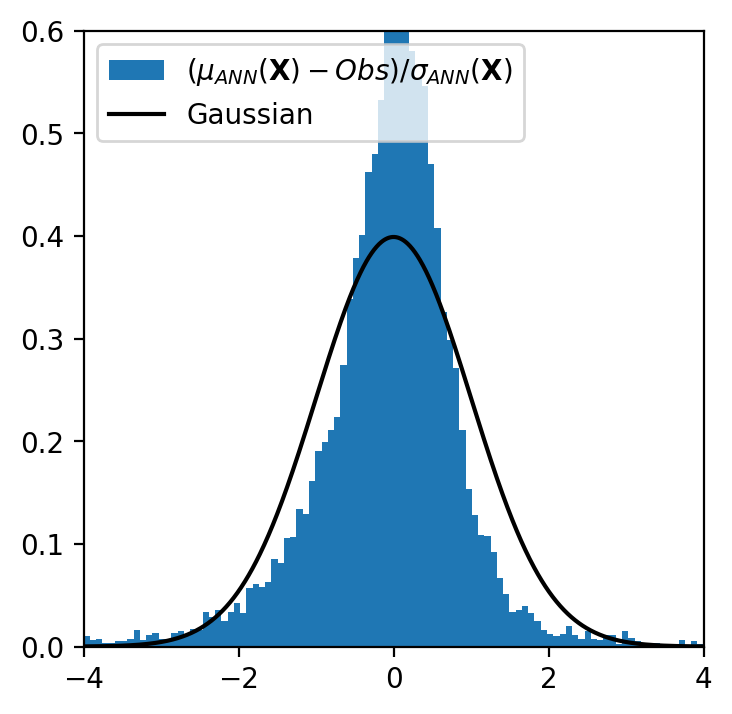

In [66]:
vd = ResidualDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)

i = 1
model = momentum_model_ensem[i]
    
error = vd.Bulk.detach().numpy() - vd.Y.detach().numpy()
error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5

fig = plt.figure(figsize=(4,4),dpi=200)
plt.hist(error_norm, bins=np.linspace(-4, 4, 100), density=True, 
         label='$(\mu_{ANN}(\mathbf{X}) - Obs)/\sigma_{ANN}(\mathbf{X})$')

mu = 0      # mean
sigma = 1   # standard deviation

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
y_ = 1/((np.pi*0.3)*(1+(x/0.3)**2))

# plt.plot(x, y_, color='r', label='Cauchy')
plt.plot(x, y, color='k', label='Gaussian')
plt.legend(loc='upper left')
plt.xlim([-4,4]) 
plt.ylim([0,0.6])
# plt.yscale('log')

In [91]:
U = np.linspace(0,20,101).reshape(-1,1)
Ta = np.ones([101,1]) * 20
To = np.ones([101,1]) * 20
RH = np.ones([101,1]) * 100
X = np.hstack([U,Ta,To,RH])
Delta = model.pred_mean(torch.tensor(X.astype('float32'))).detach().numpy()

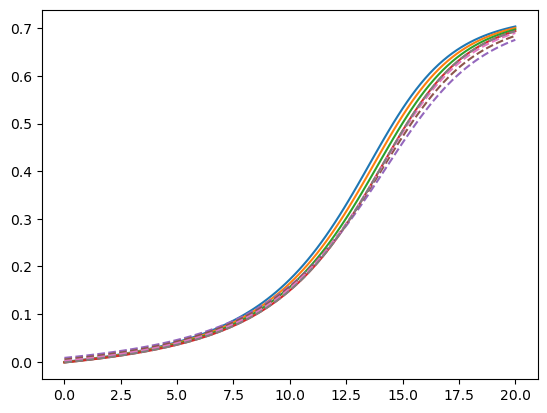

In [96]:
U = np.linspace(0,20,101).reshape(-1,1)
Ta = np.ones([101,1]) * 20
To = np.ones([101,1]) * 20

for rh in (60,70,80,90):
    RH = np.ones([101,1]) * rh
    X = np.hstack([U,Ta,To,RH])
    Delta = model.pred_mean(torch.tensor(X.astype('float32'))).detach().numpy()
    plt.plot(U.flatten(), Delta.flatten())

RH = np.ones([101,1]) * rh
Ta = np.ones([101,1]) * 20


for to in (5,10,15,20):
    To = np.ones([101,1]) * to
    X = np.hstack([U,Ta,To,RH])
    Delta = model.pred_mean(torch.tensor(X.astype('float32'))).detach().numpy()
    plt.plot(U.flatten(), Delta.flatten(), '--')

In [ ]:
''' Predictor with four inputs and four outputs '''
class Flux44(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2 (or scale)
        scale = torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([1,1,1,1]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        pass

''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff   
class Flux44diff(Flux44):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)     

In [ ]:
###### Network hyperparameter ######
para1 = {'n_in':5,'n_out':4,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':5,'n_out':4,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 10.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh', 'qair']
    okeys = ['taucx', 'taucy', 'hsc', 'hlc']
    bkeys = ['taubx', 'tauby', 'hsb', 'hlb']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    ###### Run the model 5 times ######
    for run in range(5):   
        model = Flux54diff({'mean_ann_para':para1, 'var_ann_para':para2})
        model.datasplit = split
        # training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2}
        training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
        log = model.fit(training_data, validating_data, training_paras, VERBOSE=True)
        # Later we can pick one before saving but since files are pretty small they are ok 
        model.save(fname="../../saved_model/full_anns/flux54_diff_3layers_split%g_run%g" %(i+1,run))